In [1]:
#from google.colab import drive
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.corpus import words
nltk.download('punkt')
nltk.download('words')
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import string
import re

#from google.colab import drive
#drive.mount('/content/drive')

!pip install rouge_score
from rouge_score import rouge_scorer

from ast import literal_eval
import pandas as pd

from pandas import isnull

import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siggahalldorsdottir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/siggahalldorsdottir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/siggahalldorsdottir/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/siggahalldorsdottir/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/siggahalldorsdottir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
pred_cols = [
    'predictions_covid_context_tfidf',
    'predictions_covid_context_bm25',
    'predictions_wiki_context_bm25',
    'predictions_wiki_context_tfidf',
    'predictions_wikiAPI_context_bm25',
    'predictions_wikiAPI_context_tfidf',
] 

# Import and clean data

In [3]:
df_res_squad_news = pd.read_csv('predictions/df_res_squad_top5.csv', converters={'answer': str,
                                               'predictions_covid_context_tfidf': literal_eval,
                                               'predictions_covid_context_bm25': literal_eval,
                                               'predictions_wiki_context_bm25': literal_eval,
                                               'predictions_wiki_context_tfidf': literal_eval,
                                               'predictions_wikiAPI_context_bm25': literal_eval,
                                               'predictions_wikiAPI_context_tfidf': literal_eval})
df_res_covidsquad_news = pd.read_csv('predictions/df_res_covid_squad_top5 _news.csv', converters={'answer': str,
                                              'predictions_covid_context_tfidf': literal_eval,
                                               'predictions_covid_context_bm25': literal_eval,
                                               'predictions_wiki_context_bm25': literal_eval,
                                               'predictions_wiki_context_tfidf': literal_eval,
                                               'predictions_wikiAPI_context_bm25': literal_eval,
                                               'predictions_wikiAPI_context_tfidf': literal_eval})
df_res_squad_covid = pd.read_csv('predictions/df_res_squad_coviddata_top5.csv', converters={'answer': str,
                                                'predictions_covid_context_tfidf': literal_eval,
                                               'predictions_covid_context_bm25': literal_eval,
                                               'predictions_wiki_context_bm25': literal_eval,
                                               'predictions_wiki_context_tfidf': literal_eval,
                                               'predictions_wikiAPI_context_bm25': literal_eval,
                                               'predictions_wikiAPI_context_tfidf': literal_eval})
df_res_covidsquad_covid = pd.read_csv('predictions/df_res_covid_squad_covidQA_top5.csv', converters={'answer': str,
                                                'predictions_covid_context_tfidf': literal_eval,
                                               'predictions_covid_context_bm25': literal_eval,
                                               'predictions_wiki_context_bm25': literal_eval,
                                               'predictions_wiki_context_tfidf': literal_eval,
                                               'predictions_wikiAPI_context_bm25': literal_eval,
                                               'predictions_wikiAPI_context_tfidf': literal_eval})


def replace_newline(content):
  ret_list = []
  for w in content:
    ret_list.append(w.replace('\n', ' ').lower())
  return ret_list

i=0
for df_res in [
    df_res_squad_news,
    df_res_covidsquad_news,
    df_res_squad_covid,
    df_res_covidsquad_covid,
]:
  df_res['predictions_covid_context_tfidf'] = df_res['predictions_covid_context_tfidf'].apply(lambda x: x[0])
  df_res['predictions_covid_context_bm25'] = df_res['predictions_covid_context_bm25'].apply(lambda x: x[0])
  df_res['predictions_wiki_context_bm25'] = df_res['predictions_wiki_context_bm25'].apply(lambda x: x[0])
  df_res['predictions_wiki_context_tfidf'] = df_res['predictions_wiki_context_tfidf'].apply(lambda x: x[0])
  df_res['predictions_wikiAPI_context_bm25'] = df_res['predictions_wikiAPI_context_bm25'].apply(lambda x: x[0])
  df_res['predictions_wikiAPI_context_tfidf'] = df_res['predictions_wikiAPI_context_tfidf'].apply(lambda x: x[0])

  df_res['answer'] = df_res['answer'].apply(lambda x: x.replace('\n', ' ').lower())
  df_res['predictions_covid_context_tfidf'] = df_res['predictions_covid_context_tfidf'].apply(lambda x: replace_newline(x))
  df_res['predictions_covid_context_bm25'] = df_res['predictions_covid_context_bm25'].apply(lambda x: replace_newline(x))
  df_res['predictions_wiki_context_bm25'] = df_res['predictions_wiki_context_bm25'].apply(lambda x: replace_newline(x))
  df_res['predictions_wiki_context_tfidf'] = df_res['predictions_wiki_context_tfidf'].apply(lambda x: replace_newline(x))
  df_res['predictions_wikiAPI_context_bm25'] = df_res['predictions_wikiAPI_context_bm25'].apply(lambda x: replace_newline(x))
  df_res['predictions_wikiAPI_context_tfidf'] = df_res['predictions_wikiAPI_context_tfidf'].apply(lambda x: replace_newline(x))


In [4]:
df_res_squad_news['predictions_covid_context_bm25'][0]

['depression, anxiety, insomnia, and distress',
 'depression, anxiety',
 'depression',
 'severe infectious diseases',
 'severe']

# Rouge score

In [5]:
def getRougeScore(df_res, column):
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2','rougeL'], use_stemmer=True)
  rouge1 = []
  rouge2 = []
  rougeL = []
  rouge1s = []
  rouge2s = []
  rougeLs = []
  count = 0
  for i in range(len(df_res)):
    if (len(df_res[column][i]) == 0) or (df_res[column][i] == ''):
      count += 1
      rouge1s.append(np.nan)
      rouge2s.append(np.nan)
      rougeLs.append(np.nan)
    else:
      #for j in range(1):
      prediction = df_res[column][i][0]
      #print(prediction)
      reference = df_res['answer'][i]
      #print(reference)
      #print(i)
      scores = scorer.score(str(prediction), str(reference))
      rouge1.append(scores['rouge1'])
      rouge2.append(scores['rouge2'])
      rougeL.append(scores['rougeL'])
      rouge1s.append(scores['rouge1'])
      rouge2s.append(scores['rouge2'])
      rougeLs.append(scores['rougeL'])
      
    df_res[column + '_rouge1'] = pd.Series(rouge1s)
    df_res[column + '_rouge2'] = pd.Series(rouge2s)
    df_res[column + '_rougeL'] = pd.Series(rougeLs)

  
  results = pd.DataFrame()
  results['Rouge1'] = pd.Series([np.mean(rouge1, axis=0)[0], np.mean(rouge1, axis=0)[1], np.mean(rouge1, axis=0)[2]], index=['Precision', 'Recall', 'fmeasure'])
  results['Rouge2'] = pd.Series([np.mean(rouge2, axis=0)[0], np.mean(rouge2, axis=0)[1], np.mean(rouge2, axis=0)[2]], index=['Precision', 'Recall', 'fmeasure'])
  results['RougeL'] = pd.Series([np.mean(rougeL, axis=0)[0], np.mean(rougeL, axis=0)[1], np.mean(rougeL, axis=0)[2]], index=['Precision', 'Recall', 'fmeasure'])
  results['UAQuestions'] = pd.Series([count, count, count], index=['Precision', 'Recall', 'fmeasure'])


  return results


In [6]:
def get_results_all(df_res):
  results_1 = getRougeScore(df_res, 'predictions_wiki_context_bm25')
  results_2 = getRougeScore(df_res, 'predictions_wiki_context_tfidf')
  results_3 = getRougeScore(df_res, 'predictions_wikiAPI_context_bm25')
  results_4 = getRougeScore(df_res, 'predictions_wikiAPI_context_tfidf')
  results_5 = getRougeScore(df_res, 'predictions_covid_context_bm25')
  results_6 = getRougeScore(df_res, 'predictions_covid_context_tfidf')

  return pd.concat({'predictions_wiki_context_bm25': results_1, 
                    'predictions_wiki_context_tfidf': results_2,
                    'predictions_wikiAPI_context_bm25': results_3,
                    'predictions_wikiAPI_context_tfidf': results_4,
                    'predictions_covid_context_bm25': results_5,
                    'predictions_covid_context_tfidf': results_6
                    })


In [7]:
results_squad_news = get_results_all(df_res_squad_news)
results_squad_news

Rouge1    Rouge2    RougeL  \
predictions_wiki_context_bm25     Precision  0.025599  0.003192  0.020298   
                                  Recall     0.277827  0.044340  0.243827   
                                  fmeasure   0.041382  0.005436  0.033392   
predictions_wiki_context_tfidf    Precision  0.014609  0.001908  0.012255   
                                  Recall     0.267555  0.060623  0.246483   
                                  fmeasure   0.024850  0.003289  0.020858   
predictions_wikiAPI_context_bm25  Precision  0.016688  0.001057  0.014413   
                                  Recall     0.204577  0.010903  0.186909   
                                  fmeasure   0.027555  0.001828  0.023928   
predictions_wikiAPI_context_tfidf Precision  0.028093  0.002867  0.022416   
                                  Recall     0.287977  0.028529  0.255463   
                                  fmeasure   0.042428  0.004460  0.034944   
predictions_covid_context_bm25    Precision  0.025137  0.001894  0.020296   
                                  Recall     0.277628  0.028553  0.241318   
                                  fmeasure   0.041009  0.003234  0.033381   
predictions_covid_context_tfidf   Precision  0.027612  0.002945  0.021367   
                                  Recall     0.273173  0.043281  0.232793   
                                  fmeasure   0.044157  0.004828  0.034577   

                                             UAQuestions  
predictions_wiki_context_bm25     Precision            0  
                                  Recall               0  
                                  fmeasure             0  
predictions_wiki_context_tfidf    Precision            0  
                                  Recall               0  
                                  fmeasure             0  
predictions_wikiAPI_context_bm25  Precision          185  
                                  Recall             185  
                                  fmeasure           185  
predictions_wikiAPI_context_tfidf Precision          184  
                                  Recall             184  
                                  fmeasure           184  
predictions_covid_context_bm25    Precision            0  
                                  Recall               0  
                                  fmeasure             0  
predictions_covid_context_tfidf   Precision            0  
                                  Recall               0  
                                  fmeasure             0

In [8]:
results_covd_squad_news = get_results_all(df_res_covidsquad_news)
results_covd_squad_news

Rouge1    Rouge2    RougeL  \
predictions_wiki_context_bm25     Precision  0.063946  0.006709  0.044403   
                                  Recall     0.296843  0.042161  0.224960   
                                  fmeasure   0.088684  0.009796  0.062338   
predictions_wiki_context_tfidf    Precision  0.025353  0.003608  0.020117   
                                  Recall     0.262630  0.050622  0.230376   
                                  fmeasure   0.040293  0.006104  0.032410   
predictions_wikiAPI_context_bm25  Precision  0.055343  0.005855  0.041217   
                                  Recall     0.268758  0.028056  0.216748   
                                  fmeasure   0.075275  0.007404  0.056363   
predictions_wikiAPI_context_tfidf Precision  0.059408  0.006967  0.042189   
                                  Recall     0.306116  0.038956  0.238816   
                                  fmeasure   0.084015  0.010340  0.060031   
predictions_covid_context_bm25    Precision  0.049936  0.004559  0.036185   
                                  Recall     0.287157  0.037128  0.230875   
                                  fmeasure   0.069913  0.007118  0.050790   
predictions_covid_context_tfidf   Precision  0.094066  0.010481  0.058560   
                                  Recall     0.303509  0.043452  0.221197   
                                  fmeasure   0.111808  0.013218  0.071526   

                                             UAQuestions  
predictions_wiki_context_bm25     Precision            0  
                                  Recall               0  
                                  fmeasure             0  
predictions_wiki_context_tfidf    Precision            0  
                                  Recall               0  
                                  fmeasure             0  
predictions_wikiAPI_context_bm25  Precision          184  
                                  Recall             184  
                                  fmeasure           184  
predictions_wikiAPI_context_tfidf Precision          184  
                                  Recall             184  
                                  fmeasure           184  
predictions_covid_context_bm25    Precision            0  
                                  Recall               0  
                                  fmeasure             0  
predictions_covid_context_tfidf   Precision            0  
                                  Recall               0  
                                  fmeasure             0

In [9]:
results_squad_covid = get_results_all(df_res_squad_covid)
results_squad_covid

Rouge1    Rouge2    RougeL  \
predictions_wiki_context_bm25     Precision  0.032407  0.004831  0.031573   
                                  Recall     0.055821  0.014333  0.054912   
                                  fmeasure   0.034937  0.006952  0.034067   
predictions_wiki_context_tfidf    Precision  0.028886  0.010769  0.028886   
                                  Recall     0.065496  0.010909  0.065496   
                                  fmeasure   0.030864  0.010833  0.030864   
predictions_wikiAPI_context_bm25  Precision  0.065108  0.012195  0.065108   
                                  Recall     0.088932  0.012195  0.088932   
                                  fmeasure   0.061692  0.012195  0.061692   
predictions_wikiAPI_context_tfidf Precision  0.048238  0.012195  0.048238   
                                  Recall     0.040955  0.012195  0.040955   
                                  fmeasure   0.042393  0.012195  0.042393   
predictions_covid_context_bm25    Precision  0.425593  0.272865  0.420503   
                                  Recall     0.526329  0.325417  0.518361   
                                  fmeasure   0.442390  0.281867  0.436319   
predictions_covid_context_tfidf   Precision  0.435019  0.279147  0.430583   
                                  Recall     0.489410  0.305538  0.485377   
                                  fmeasure   0.435188  0.275014  0.431299   

                                             UAQuestions  
predictions_wiki_context_bm25     Precision            0  
                                  Recall               0  
                                  fmeasure             0  
predictions_wiki_context_tfidf    Precision            0  
                                  Recall               0  
                                  fmeasure             0  
predictions_wikiAPI_context_bm25  Precision           59  
                                  Recall              59  
                                  fmeasure            59  
predictions_wikiAPI_context_tfidf Precision           59  
                                  Recall              59  
                                  fmeasure            59  
predictions_covid_context_bm25    Precision            0  
                                  Recall               0  
                                  fmeasure             0  
predictions_covid_context_tfidf   Precision            0  
                                  Recall               0  
                                  fmeasure             0

In [10]:
results_covidsquad_covid = get_results_all(df_res_covidsquad_covid)
results_covidsquad_covid 

Rouge1    Rouge2    RougeL  \
predictions_wiki_context_bm25     Precision  0.081158  0.008314  0.076659   
                                  Recall     0.068941  0.016969  0.063649   
                                  fmeasure   0.060582  0.009982  0.056603   
predictions_wiki_context_tfidf    Precision  0.053583  0.012103  0.051670   
                                  Recall     0.060580  0.012727  0.056042   
                                  fmeasure   0.048535  0.012372  0.046190   
predictions_wikiAPI_context_bm25  Precision  0.077516  0.012195  0.077516   
                                  Recall     0.065523  0.012195  0.065523   
                                  fmeasure   0.061202  0.012195  0.061202   
predictions_wikiAPI_context_tfidf Precision  0.091720  0.003049  0.089034   
                                  Recall     0.075598  0.006098  0.072220   
                                  fmeasure   0.071165  0.004065  0.068430   
predictions_covid_context_bm25    Precision  0.496102  0.341765  0.492639   
                                  Recall     0.498150  0.363856  0.494592   
                                  fmeasure   0.468040  0.328912  0.464710   
predictions_covid_context_tfidf   Precision  0.566761  0.413155  0.558104   
                                  Recall     0.541713  0.425954  0.534320   
                                  fmeasure   0.521079  0.394068  0.513396   

                                             UAQuestions  
predictions_wiki_context_bm25     Precision            0  
                                  Recall               0  
                                  fmeasure             0  
predictions_wiki_context_tfidf    Precision            0  
                                  Recall               0  
                                  fmeasure             0  
predictions_wikiAPI_context_bm25  Precision           59  
                                  Recall              59  
                                  fmeasure            59  
predictions_wikiAPI_context_tfidf Precision           59  
                                  Recall              59  
                                  fmeasure            59  
predictions_covid_context_bm25    Precision            0  
                                  Recall               0  
                                  fmeasure             0  
predictions_covid_context_tfidf   Precision            0  
                                  Recall               0  
                                  fmeasure             0

<function matplotlib.pyplot.show(close=None, block=None)>

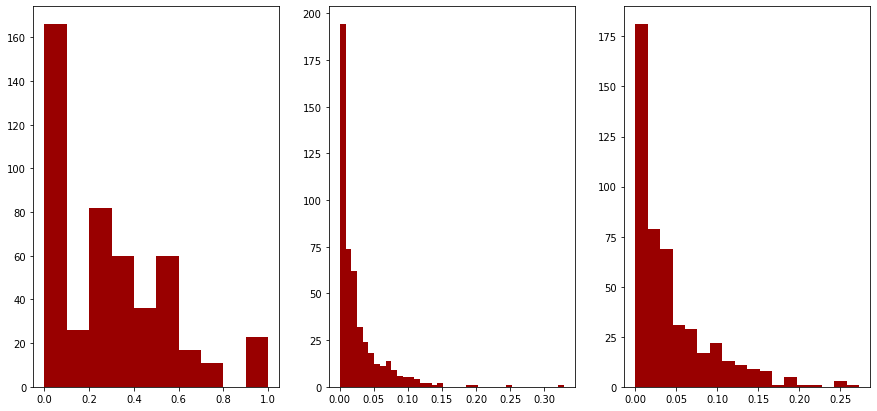

In [11]:
rougeL_pre = []
rougeL_recall = []
rougeL_f = []
for i in range(len(df_res_squad_news)):
  rougeL_pre.append(df_res_squad_news['predictions_covid_context_bm25_rouge1'][i][0])
  rougeL_recall.append(df_res_squad_news['predictions_covid_context_bm25_rouge1'][i][1])
  rougeL_f.append(df_res_squad_news['predictions_covid_context_bm25_rouge1'][i][2])


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,7))
ax1.hist(rougeL_recall, bins='auto', color='#990000')
ax2.hist(rougeL_pre, bins='auto', color='#990000')
ax3.hist(rougeL_f, bins='auto', color='#990000')

plt.show

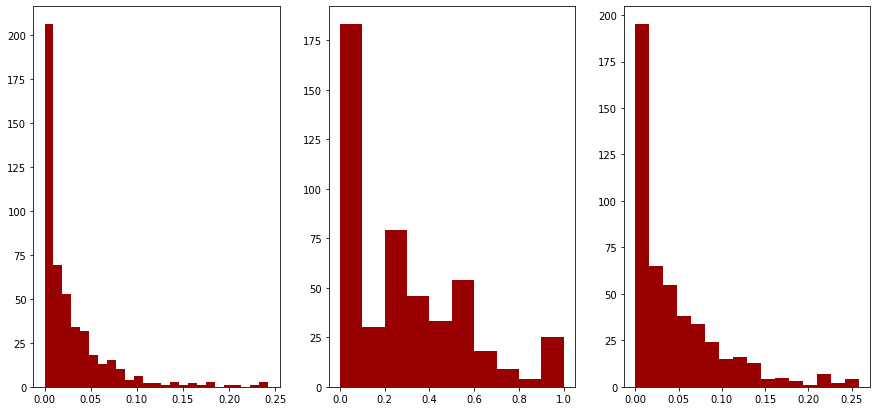

In [12]:
rougeL_pre = []
rougeL_recall = []
rougeL_f = []
for i in range(len(df_res_squad_news)):
  rougeL_pre.append(df_res_squad_news['predictions_covid_context_tfidf_rouge1'][i][0])
  rougeL_recall.append(df_res_squad_news['predictions_covid_context_tfidf_rouge1'][i][1])
  rougeL_f.append(df_res_squad_news['predictions_covid_context_tfidf_rouge1'][i][2])


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,7))
ax1.hist(rougeL_pre, bins='auto', color='#990000')
ax2.hist(rougeL_recall, bins='auto', color='#990000')
ax3.hist(rougeL_f, bins='auto', color='#990000')

plt.show()

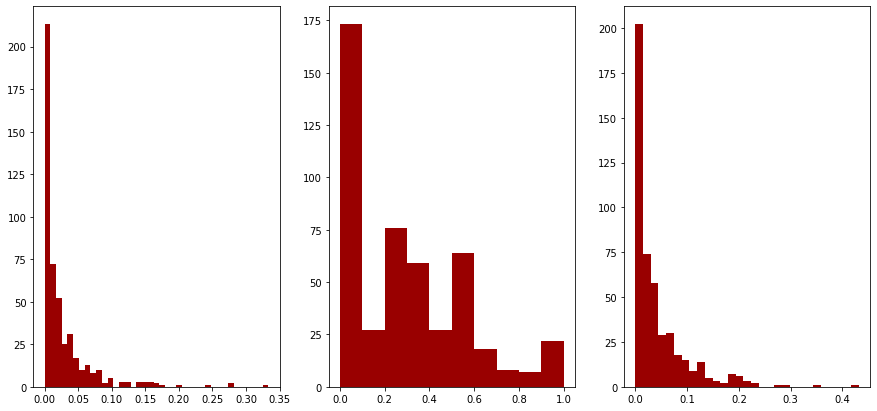

In [13]:
rougeL_pre = []
rougeL_recall = []
rougeL_f = []
for i in range(len(df_res_squad_news)):
  rougeL_pre.append(df_res_squad_news['predictions_wiki_context_bm25_rouge1'][i][0])
  rougeL_recall.append(df_res_squad_news['predictions_wiki_context_bm25_rouge1'][i][1])
  rougeL_f.append(df_res_squad_news['predictions_wiki_context_bm25_rouge1'][i][2])


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,7))
ax1.hist(rougeL_pre, bins='auto', color='#990000')
ax2.hist(rougeL_recall, bins='auto', color='#990000')
ax3.hist(rougeL_f, bins='auto', color='#990000')

plt.show()

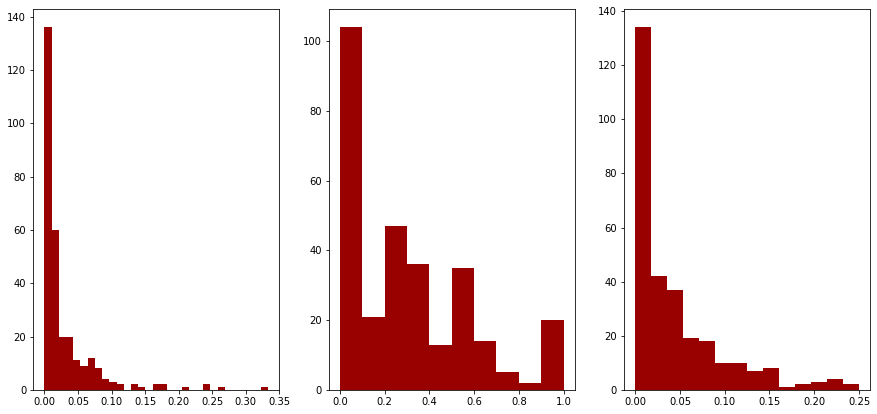

In [14]:
rougeL_pre = []
rougeL_recall = []
rougeL_f = []
for i in range(len(df_res_squad_news)):
  if not pd.isna(df_res_squad_news['predictions_wikiAPI_context_tfidf_rouge1'][i]):
    rougeL_pre.append(df_res_squad_news['predictions_wikiAPI_context_tfidf_rouge1'][i][0])
    rougeL_recall.append(df_res_squad_news['predictions_wikiAPI_context_tfidf_rouge1'][i][1])
    rougeL_f.append(df_res_squad_news['predictions_wikiAPI_context_tfidf_rouge1'][i][2])


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,7))
ax1.hist(rougeL_pre, bins='auto', color='#990000')
ax2.hist(rougeL_recall, bins='auto', color='#990000')
ax3.hist(rougeL_f, bins='auto', color='#990000')

plt.show()

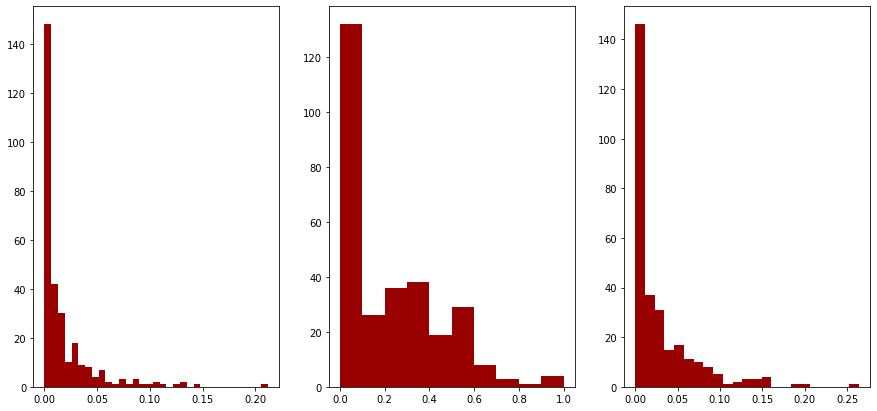

In [15]:
rougeL_pre = []
rougeL_recall = []
rougeL_f = []
for i in range(len(df_res_squad_news)):
  if not pd.isna(df_res_squad_news['predictions_wikiAPI_context_bm25_rouge1'][i]):
    rougeL_pre.append(df_res_squad_news['predictions_wikiAPI_context_bm25_rouge1'][i][0])
    rougeL_recall.append(df_res_squad_news['predictions_wikiAPI_context_bm25_rouge1'][i][1])
    rougeL_f.append(df_res_squad_news['predictions_wikiAPI_context_bm25_rouge1'][i][2])


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,7))
ax1.hist(rougeL_pre, bins='auto', color='#990000')
ax2.hist(rougeL_recall, bins='auto', color='#990000')
ax3.hist(rougeL_f, bins='auto', color='#990000')

plt.show()

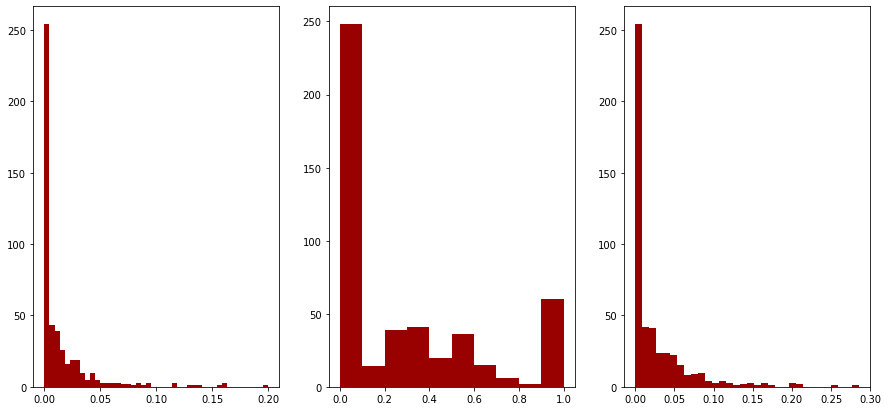

In [16]:
rougeL_pre = []
rougeL_recall = []
rougeL_f = []
for i in range(len(df_res_squad_news)):
  rougeL_pre.append(df_res_squad_news['predictions_wiki_context_tfidf_rouge1'][i][0])
  rougeL_recall.append(df_res_squad_news['predictions_wiki_context_tfidf_rouge1'][i][1])
  rougeL_f.append(df_res_squad_news['predictions_wiki_context_tfidf_rouge1'][i][2])


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,7))
ax1.hist(rougeL_pre, bins='auto', color='#990000')
ax2.hist(rougeL_recall, bins='auto', color='#990000')
ax3.hist(rougeL_f, bins='auto', color='#990000')

plt.show()

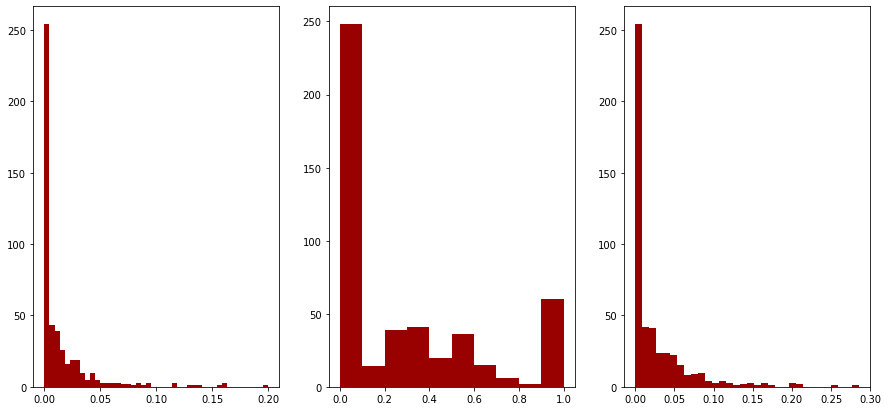

In [17]:
rougeL_pre = []
rougeL_recall = []
rougeL_f = []
for i in range(len(df_res_squad_news)):
  rougeL_pre.append(df_res_squad_news['predictions_wiki_context_tfidf_rouge1'][i][0])
  rougeL_recall.append(df_res_squad_news['predictions_wiki_context_tfidf_rouge1'][i][1])
  rougeL_f.append(df_res_squad_news['predictions_wiki_context_tfidf_rouge1'][i][2])


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,7))
ax1.hist(rougeL_pre, bins='auto', color='#990000')
ax2.hist(rougeL_recall, bins='auto', color='#990000')
ax3.hist(rougeL_f, bins='auto', color='#990000')

plt.show()

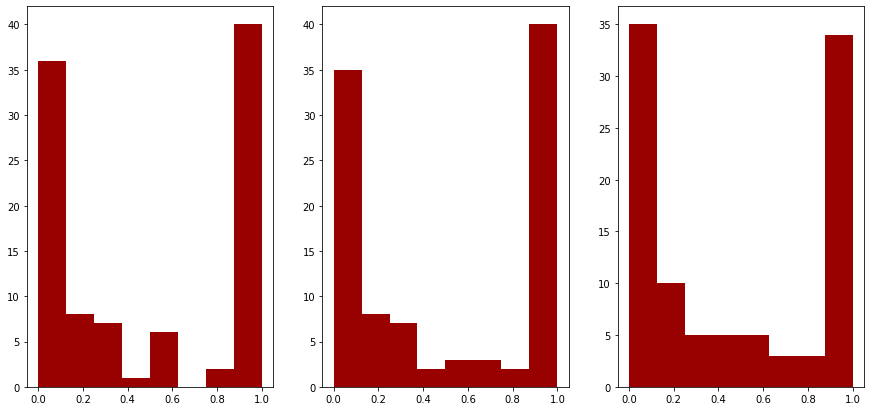

In [18]:
rougeL_pre = []
rougeL_recall = []
rougeL_f = []
for i in range(len(df_res_covidsquad_covid)):
  rougeL_pre.append(df_res_covidsquad_covid['predictions_covid_context_bm25_rougeL'][i][0])
  rougeL_recall.append(df_res_covidsquad_covid['predictions_covid_context_bm25_rougeL'][i][1])
  rougeL_f.append(df_res_covidsquad_covid['predictions_covid_context_bm25_rougeL'][i][2])


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,7))
ax1.hist(rougeL_pre, bins='auto', color='#990000')
ax2.hist(rougeL_recall, bins='auto', color='#990000')
ax3.hist(rougeL_f, bins='auto', color='#990000')



plt.show()

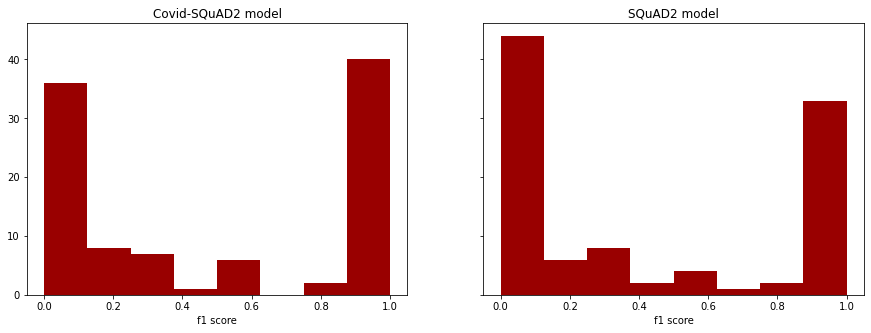

In [19]:
covid_squad = []
squad = []
for i in range(len(df_res_covidsquad_covid)):
  squad.append(df_res_squad_covid['predictions_covid_context_bm25_rougeL'][i][0])
  covid_squad.append(df_res_covidsquad_covid['predictions_covid_context_bm25_rougeL'][i][0])


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)
ax1.title.set_text('Covid-SQuAD2 model')
ax1.hist(covid_squad, bins='auto', color='#990000')
ax1.set_xlabel('f1 score')
ax2.title.set_text('SQuAD2 model')
ax2.hist(squad, bins='auto', color='#990000')
ax2.set_xlabel('f1 score')

#plt.savefig('plot_f1.png')
plt.show()

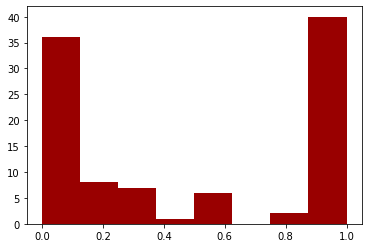

In [20]:
rougeL_pre = []
rougeL_recall = []
rougeL_f = []
for i in range(len(df_res_covidsquad_covid)):
  rougeL_pre.append(df_res_covidsquad_covid['predictions_covid_context_bm25_rougeL'][i][0])


f, ax1 = plt.subplots(1, 1)
ax1.hist(rougeL_pre, bins='auto', color='#990000')



plt.show()

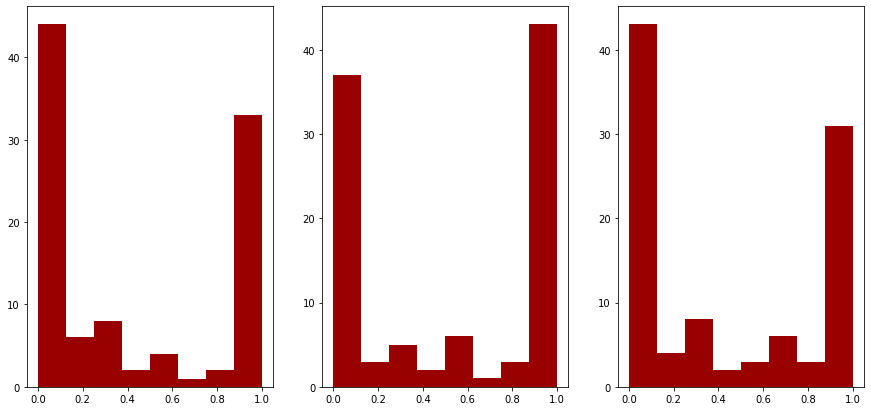

In [21]:
rougeL_pre = []
rougeL_recall = []
rougeL_f = []
for i in range(len(df_res_covidsquad_covid)):
  rougeL_pre.append(df_res_squad_covid['predictions_covid_context_bm25_rougeL'][i][0])
  rougeL_recall.append(df_res_squad_covid['predictions_covid_context_bm25_rougeL'][i][1])
  rougeL_f.append(df_res_squad_covid['predictions_covid_context_bm25_rougeL'][i][2])


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,7))
ax1.hist(rougeL_pre, bins='auto', color='#990000')
ax2.hist(rougeL_recall, bins='auto', color='#990000')
ax3.hist(rougeL_f, bins='auto', color='#990000')



plt.show()

# Keyword analysis

In [22]:
for df in [
    df_res_squad_news,
    df_res_covidsquad_news,
    df_res_squad_covid,
    df_res_covidsquad_covid,
]:
    for col in pred_cols:
        print(col)
        
        try:
            df[f'{col}_top_1'] = df[f'{col}'].apply(
                lambda x: x[0]
                if len(x) > 0 else x
            )
        except Exception as e:
            print(e)
        
        df[f'{col}_top_5'] = df[f'{col}'].apply(
            lambda x: ' '.join(x)
        )

predictions_covid_context_tfidf
predictions_covid_context_bm25
predictions_wiki_context_bm25
predictions_wiki_context_tfidf
predictions_wikiAPI_context_bm25
predictions_wikiAPI_context_tfidf
predictions_covid_context_tfidf
predictions_covid_context_bm25
predictions_wiki_context_bm25
predictions_wiki_context_tfidf
predictions_wikiAPI_context_bm25
predictions_wikiAPI_context_tfidf
predictions_covid_context_tfidf
predictions_covid_context_bm25
predictions_wiki_context_bm25
predictions_wiki_context_tfidf
predictions_wikiAPI_context_bm25
predictions_wikiAPI_context_tfidf
predictions_covid_context_tfidf
predictions_covid_context_bm25
predictions_wiki_context_bm25
predictions_wiki_context_tfidf
predictions_wikiAPI_context_bm25
predictions_wikiAPI_context_tfidf


In [23]:
# Defining stopwords, exclude_words and so on
stopwords = set(stopwords.words('english'))
common_words = words.words()
# exclude common words (like 'able', 'ball' etc..) for better matching
exclude_words = stopwords | set(string.punctuation) # | set(common_words)
tokenizer = RegexpTokenizer(r'\w+')

In [24]:
# function for removing stopwords, punctuation and common words
def rm_stop_punct(string, exclude_words):
    tokenized_text = nltk.word_tokenize(string)
    
    #tokenized_text = tokenizer.tokenize(string)
    
    text_no_stop_words_punct = [t for t in tokenized_text if t not in exclude_words]
    
    text_no_stop_words_punct = re.findall(r'\w+', ' '.join(text_no_stop_words_punct).lower())

    return text_no_stop_words_punct

In [25]:
from tqdm import tqdm
tqdm.pandas()

for df in [
    df_res_squad_news,
    df_res_covidsquad_news,
    df_res_squad_covid,
    df_res_covidsquad_covid,
]:
    
    df['answer_preprocessed'] = df.answer.progress_apply(
        lambda text: rm_stop_punct(text, exclude_words=exclude_words)
        if isinstance(text, str) else ''
    )
    
    for col in pred_cols:
        
        df[f'{col}_top_1_preprocessed'] = df[f'{col}_top_1'].progress_apply(
            lambda text: rm_stop_punct(text, exclude_words=exclude_words)
            if isinstance(text, str) else ''
        )
        
        df[f'{col}_top_5_preprocessed'] = df[f'{col}_top_5'].progress_apply(
            lambda text: rm_stop_punct(text, exclude_words=exclude_words)
            if isinstance(text, str) else ''
        )

100%|██████████| 100/100 [00:00<00:00, 5138.25it/s]


In [26]:
for df in [
    df_res_squad_news,
    df_res_covidsquad_news,
    df_res_squad_covid,
    df_res_covidsquad_covid,
]:
    
    for col in pred_cols:

        df[f'{col}_intersection_top_1'] = [list() for _ in range(len(df.index))]
        df[f'{col}_intersection_top_5'] = [list() for _ in range(len(df.index))]

        for i in tqdm(range(len(df.index))):
            a = df.answer_preprocessed[i]
            #b = df.iloc[i].predictions_covid_context_bm25_top_1_preprocessed
            b = df.iloc[i][f'{col}_top_1_preprocessed']
            # c = df.iloc[i].predictions_covid_context_bm25_top_5_preprocessed
            c = df.iloc[i][f'{col}_top_1_preprocessed']

            df.loc[i, f'{col}_intersection_top_1'].append(list(set(a) & set(b)))
            df.loc[i, f'{col}_intersection_top_5'].append(list(set(a) & set(c)))

        df[f'{col}_intersection_top_1'] = df[f'{col}_intersection_top_1'].apply(
            lambda x: x[0]
        )

        df[f'{col}_intersection_top_5'] = df[f'{col}_intersection_top_5'].apply(
            lambda x: x[0]
        )

100%|██████████| 100/100 [00:00<00:00, 4065.71it/s]


In [27]:
for df in [
    df_res_squad_news,
    df_res_covidsquad_news,
    df_res_squad_covid,
    df_res_covidsquad_covid,
]:
    
    for col in pred_cols:

        df[f'{col}_top_1_pct_in_answer'] = 0.0
        df[f'{col}_top_5_pct_in_answer'] = 0.0
        
        df[f'{col}_top_1_pct_in_answer_tf'] = False
        df[f'{col}_top_5_pct_in_answer_tf'] = False

        for i in tqdm(range(len(df.index))):
            a = len(df.iloc[i][f'{col}_intersection_top_1'])
            b = len(df.iloc[i][f'answer_preprocessed'])

            if a > 0:
                df.loc[i, f'{col}_top_1_pct_in_answer'] = (a / b)
                df.loc[i, f'{col}_top_1_pct_in_answer_tf'] = True
            else:
                df.loc[i, f'{col}_top_1_pct_in_answer'] = np.nan

            c = len(df.iloc[i][f'{col}_intersection_top_5'])
            d = len(df.iloc[i]['answer_preprocessed'])

            if c > 0:
                df.loc[i, f'{col}_top_5_pct_in_answer'] = (c / d)
                df.loc[i, f'{col}_top_5_pct_in_answer_tf'] = True
            else:
                df.loc[i, f'{col}_top_5_pct_in_answer'] = np.nan

100%|██████████| 100/100 [00:00<00:00, 1433.11it/s]


In [28]:
cols_keywords = [col for col in df_res_squad_news.columns.tolist() if 'answer_tf' in col]
cols_keywords

['predictions_covid_context_tfidf_top_1_pct_in_answer_tf',
 'predictions_covid_context_tfidf_top_5_pct_in_answer_tf',
 'predictions_covid_context_bm25_top_1_pct_in_answer_tf',
 'predictions_covid_context_bm25_top_5_pct_in_answer_tf',
 'predictions_wiki_context_bm25_top_1_pct_in_answer_tf',
 'predictions_wiki_context_bm25_top_5_pct_in_answer_tf',
 'predictions_wiki_context_tfidf_top_1_pct_in_answer_tf',
 'predictions_wiki_context_tfidf_top_5_pct_in_answer_tf',
 'predictions_wikiAPI_context_bm25_top_1_pct_in_answer_tf',
 'predictions_wikiAPI_context_bm25_top_5_pct_in_answer_tf',
 'predictions_wikiAPI_context_tfidf_top_1_pct_in_answer_tf',
 'predictions_wikiAPI_context_tfidf_top_5_pct_in_answer_tf']

In [29]:
cols_pct = [col for col in df_res_squad_news.columns.tolist() if 'pct_in_answer' in col and 'answer_tf' not in col]
cols_pct

['predictions_covid_context_tfidf_top_1_pct_in_answer',
 'predictions_covid_context_tfidf_top_5_pct_in_answer',
 'predictions_covid_context_bm25_top_1_pct_in_answer',
 'predictions_covid_context_bm25_top_5_pct_in_answer',
 'predictions_wiki_context_bm25_top_1_pct_in_answer',
 'predictions_wiki_context_bm25_top_5_pct_in_answer',
 'predictions_wiki_context_tfidf_top_1_pct_in_answer',
 'predictions_wiki_context_tfidf_top_5_pct_in_answer',
 'predictions_wikiAPI_context_bm25_top_1_pct_in_answer',
 'predictions_wikiAPI_context_bm25_top_5_pct_in_answer',
 'predictions_wikiAPI_context_tfidf_top_1_pct_in_answer',
 'predictions_wikiAPI_context_tfidf_top_5_pct_in_answer']

In [30]:
for df, df_name in zip(
    [
      df_res_squad_news,
      df_res_covidsquad_news,
      df_res_squad_covid,
      df_res_covidsquad_covid,
    ], 
    [
'df_res_squad_news',
'df_res_covidsquad_news',
'df_res_squad_covid',
'df_res_covidsquad_covid',
    ]
):
    print(df_name)
    for col in cols_pct:
        print(f'''Column : {col} \t: {np.nanmean(df[f'{col}'])}''')
        
    print()

df_res_squad_news
Column : predictions_covid_context_tfidf_top_1_pct_in_answer 	: 0.035382494486203425
Column : predictions_covid_context_tfidf_top_5_pct_in_answer 	: 0.035382494486203425
Column : predictions_covid_context_bm25_top_1_pct_in_answer 	: 0.03349978364782986
Column : predictions_covid_context_bm25_top_5_pct_in_answer 	: 0.03349978364782986
Column : predictions_wiki_context_bm25_top_1_pct_in_answer 	: 0.04346334292931155
Column : predictions_wiki_context_bm25_top_5_pct_in_answer 	: 0.04346334292931155
Column : predictions_wiki_context_tfidf_top_1_pct_in_answer 	: 0.031062159205828027
Column : predictions_wiki_context_tfidf_top_5_pct_in_answer 	: 0.031062159205828027
Column : predictions_wikiAPI_context_bm25_top_1_pct_in_answer 	: 0.03896764522602747
Column : predictions_wikiAPI_context_bm25_top_5_pct_in_answer 	: 0.03896764522602747
Column : predictions_wikiAPI_context_tfidf_top_1_pct_in_answer 	: 0.0385351571027269
Column : predictions_wikiAPI_context_tfidf_top_5_pct_in_ans

In [31]:
for df, df_name in zip(
    [
        df_res_squad_news,
        df_res_covidsquad_news,
        df_res_squad_covid,
        df_res_covidsquad_covid,
    ], 
    [
       'df_res_squad_news',
       'df_res_covidsquad_news',
       'df_res_squad_covid',
       'df_res_covidsquad_covid',
    ]
):
    print(df_name)
    for col in cols_keywords:
        # summing over "True" values, True = 1, False = 0
        print(f'''Column : {col} : {np.sum(df[f'{col}'])} ({len(df[f'{col}'])}) : {np.sum(df[f'{col}']) / len(df)}''')
        
    print()

df_res_squad_news
Column : predictions_covid_context_tfidf_top_1_pct_in_answer_tf : 173 (481) : 0.3596673596673597
Column : predictions_covid_context_tfidf_top_5_pct_in_answer_tf : 173 (481) : 0.3596673596673597
Column : predictions_covid_context_bm25_top_1_pct_in_answer_tf : 166 (481) : 0.34511434511434513
Column : predictions_covid_context_bm25_top_5_pct_in_answer_tf : 166 (481) : 0.34511434511434513
Column : predictions_wiki_context_bm25_top_1_pct_in_answer_tf : 167 (481) : 0.3471933471933472
Column : predictions_wiki_context_bm25_top_5_pct_in_answer_tf : 167 (481) : 0.3471933471933472
Column : predictions_wiki_context_tfidf_top_1_pct_in_answer_tf : 185 (481) : 0.38461538461538464
Column : predictions_wiki_context_tfidf_top_5_pct_in_answer_tf : 185 (481) : 0.38461538461538464
Column : predictions_wikiAPI_context_bm25_top_1_pct_in_answer_tf : 64 (481) : 0.13305613305613306
Column : predictions_wikiAPI_context_bm25_top_5_pct_in_answer_tf : 64 (481) : 0.13305613305613306
Column : predi

In [32]:
df_res_squad_news

,question,answer,wrong_answer,predictions_covid_context_tfidf,predictions_covid_context_bm25,predictions_wiki_context_bm25,predictions_wiki_context_tfidf,predictions_wikiAPI_context_bm25,predictions_wikiAPI_context_tfidf,predictions_wiki_context_bm25_rouge1,...,predictions_wiki_context_tfidf_top_1_pct_in_answer_tf,predictions_wiki_context_tfidf_top_5_pct_in_answer_tf,predictions_wikiAPI_context_bm25_top_1_pct_in_answer,predictions_wikiAPI_context_bm25_top_5_pct_in_answer,predictions_wikiAPI_context_bm25_top_1_pct_in_answer_tf,predictions_wikiAPI_context_bm25_top_5_pct_in_answer_tf,predictions_wikiAPI_context_tfidf_top_1_pct_in_answer,predictions_wikiAPI_context_tfidf_top_5_pct_in_answer,predictions_wikiAPI_context_tfidf_top_1_pct_in_answer_tf,predictions_wikiAPI_context_tfidf_top_5_pct_in_answer_tf
0,"Covid 19, What are the symptoms?","symptoms include fever, coughing, sore throat,...","As cases of coronavirus surge, health authorit...","[smoking, depending on where they live, their ...","[depression, anxiety, insomnia, and distress, ...","[usually have mild to moderate severity, malar...","[covid-19, symptoms, symptoms, symptoms, sympt...","[fatigue, shortness of breath and chest pain, ...","[few or no symptoms, mild and disappear withou...","(0.020833333333333332, 0.3333333333333333, 0.0...",...,True,True,0.062500,0.062500,True,True,0.020833,0.020833,True,True
1,"Covid 19, When should I get tested?",your doctor will tell you if you need to get t...,If you have been in contact with a person with...,"[ten days, depending on where they live, their...","[old, may be accessed through medical provider...","[october 2020, 9 october 2020, july 2020, marc...","[october 1, 2020, october 2020, march 2020, oc...","[2019, every two days, australia, 5–30 minutes...","[5–30 minutes, ten days, in hong kong test sub...","(0.0, 0.0, 0.0)",...,False,False,NaN,NaN,False,False,NaN,NaN,False,False
2,"Covid 19, What's the difference between physic...","as cases of coronavirus surge, health authorit...","Remember, the vast majority of Australians are...","[depending on where they live, their travel hi...","[ous’ coug, the pollination occurs with no pol...",[any concentration of individuals outside thei...,"[social, rescue, covid-19, isolation component...",[those considered at highest risk were told to...,[physical separation which prevents transmissi...,"(0.07207207207207207, 0.5333333333333333, 0.12...",...,True,True,NaN,NaN,False,False,0.028986,0.028986,True,True
3,"Covid 19, How do I practice physical distancing?",if you have been in contact with a person with...,Other countries have closed schools and univer...,"[smoking, depending on where they live, their ...","[ous’ coug, .html (2020)., the united states n...","[when in public, attended parties, face masks,...","[actions, cdc, practice, covid-19, pandemic]","[rearranging classrooms, staying at home, limi...","[keeping a certain distance from others, face ...","(0.008658008658008658, 0.6666666666666666, 0.0...",...,False,False,NaN,NaN,False,False,0.008197,0.008197,True,True
4,"Covid 19, What's closed?",physical distancing is the reason the federal ...,"Symptoms include fever, coughing, sore throat,...","[there is no treatment for this virus, more ca...","[seafood market, school, day care centres and ...","[schools, bars, restaurants, and places of wor...","[covid-19, covid-19, covid-19., covid-19, cdc]","[testing sites, factories and workplaces, 500,...","[industries, community quarantines in the phil...","(0.009433962264150943, 0.42857142857142855, 0....",...,True,True,0.004673,0.004673,True,True,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,"Covid 19, Is the presence of a fever always th...",symptoms of covid-19 resemble the flu and incl...,"No, for several reasons, says Peter Hotez, dea...","[depending on where they live, their travel hi...",[more cases of covid-19 are likely to be ident...,"[bats, no antiviral medicine for

# TFIDF

In [33]:
import nltk
from scipy import sparse
#call the nltk downloader
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
# punkt
# wordnet

from nltk.stem import WordNetLemmatizer

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import issparse
from scipy.spatial.distance import cosine
    

def lemmatize_sentence(sentence_vect):
  lemmatized_vect = []
  
  for sentence in sentence_vect:
    curr_vect = []
    for word in sentence.split(' '):
      curr_vect.append(lemmatizer.lemmatize(word, pos='a'))
    lemmatized_vect.append(' '.join(curr_vect))
  return lemmatized_vect

def stemSentence(s):
  if isinstance(s, list):
    stem_list = []
    for sentence in s:
      token_words = word_tokenize(str(sentence))
      stem_list.append(' '.join([porter.stem(y) for y in token_words]))
    return stem_list
  token_words=word_tokenize(str(s))
  return [porter.stem(y) for y in token_words]

def get_vectorized(pred_ans, tfidf_vectorizer):
    if len(pred_ans) > 0:
      return [tfidf_vectorizer.transform(x) for x in pred_ans if len(x) > 0]
    return []

def add_vector(column, vectorizer):
    pred_vec = get_vectorized(df_res[column], vectorizer)
    df_temp = pd.DataFrame({column.replace('lemmatized', 'vect'): pred_vec})
    df_ret = df_res.merge(df_temp, 'left', left_index=True, right_index=True)
    return df_ret

def get_distance(row, column):
  answer_vect = row['answer_vect']
  pred_vect = row[column]
  dist_vect = []

  if isinstance(pred_vect, float):
    #print('float')
    dist_vect.append(0)
  else:
    for pred in pred_vect:
      if not issparse(pred):
        dist_vect.append(0)
      else:
        dist_vect.append(1-cosine(answer_vect.toarray(), pred.toarray()))
  while len(dist_vect) < 5:
    dist_vect.append(0)
  return np.array(dist_vect)

dfs = [
    df_res_squad_news,
    df_res_covidsquad_news,
    df_res_squad_covid,
    df_res_covidsquad_covid,
  ] 

for i, df_res in enumerate(dfs):
    lemmatizer = WordNetLemmatizer()
    #df_res['answer'][0]
    df_res['answer'] = df_res['answer'].apply(lambda x: x.replace('\n', ' ').lower())
    df_res['predictions_covid_context_tfidf_lemmatized'] = df_res['predictions_covid_context_tfidf'].apply(lemmatize_sentence)
    df_res['predictions_covid_context_bm25_lemmatized'] = df_res['predictions_covid_context_bm25'].apply(lemmatize_sentence)
    df_res['predictions_wiki_context_bm25_lemmatized'] = df_res['predictions_wiki_context_bm25'].apply(lemmatize_sentence)
    df_res['predictions_wiki_context_tfidf_lemmatized'] = df_res['predictions_wiki_context_tfidf'].apply(lemmatize_sentence)
    df_res['predictions_wikiAPI_context_bm25_lemmatized'] = df_res['predictions_wikiAPI_context_bm25'].apply(lemmatize_sentence)
    df_res['predictions_wikiAPI_context_tfidf_lemmatized'] = df_res['predictions_wikiAPI_context_tfidf'].apply(lemmatize_sentence)
    print(i)
    porter = PorterStemmer()

    df_res['answer_stemmed'] = df_res['answer'].apply(stemSentence)
    df_res['predictions_covid_context_tfidf_stemmed'] = df_res['predictions_covid_context_tfidf_lemmatized'].apply(stemSentence)
    df_res['predictions_covid_context_bm25_stemmed'] = df_res['predictions_covid_context_bm25_lemmatized'].apply(stemSentence)
    df_res['predictions_wiki_context_bm25_stemmed'] = df_res['predictions_wiki_context_bm25_lemmatized'].apply(stemSentence)
    df_res['predictions_wiki_context_tfidf_stemmed'] = df_res['predictions_wiki_context_tfidf_lemmatized'].apply(stemSentence)
    df_res['predictions_wikiAPI_context_bm25_stemmed'] = df_res['predictions_wikiAPI_context_bm25_lemmatized'].apply(stemSentence)
    df_res['predictions_wikiAPI_context_tfidf_stemmed'] = df_res['predictions_wikiAPI_context_tfidf_lemmatized'].apply(stemSentence)
    print(i)

    vectorizer = TfidfVectorizer(stop_words='english')
    answers_vect = vectorizer.fit_transform(df_res['answer'].values.astype('U'), vectorizer)

    df_res = add_vector('predictions_covid_context_tfidf_lemmatized', vectorizer)
    df_res = add_vector('predictions_covid_context_bm25_lemmatized', vectorizer)
    df_res = add_vector('predictions_wiki_context_bm25_lemmatized', vectorizer)
    df_res = add_vector('predictions_wiki_context_tfidf_lemmatized', vectorizer)
    df_res = add_vector('predictions_wikiAPI_context_bm25_lemmatized', vectorizer)
    df_res = add_vector('predictions_wikiAPI_context_tfidf_lemmatized', vectorizer)
    print(i)

    df_res = df_res.merge(pd.DataFrame(answers_vect, columns=['answer_vect']), 'left', left_index=True, right_index=True)
    #df_res['answer_vect'] = [i for i in answers_vect]
    #print(df_res)
    
    #print(df_res.apply(get_distance, args=['predictions_covid_context_tfidf_vect'], axis=1))
    df_res['predictions_covid_context_tfidf_dist'] = df_res.apply(get_distance, args=['predictions_covid_context_tfidf_vect'], axis=1)
    df_res['predictions_covid_context_bm25_dist'] = df_res.apply(get_distance, args=['predictions_covid_context_bm25_vect'], axis=1)
    df_res['predictions_wiki_context_bm25_dist'] = df_res.apply(get_distance, args=['predictions_wiki_context_bm25_vect'], axis=1)
    df_res['predictions_wiki_context_tfidf_dist'] = df_res.apply(get_distance, args=['predictions_wiki_context_tfidf_vect'], axis=1)
    df_res['predictions_wikiAPI_context_bm25_dist'] = df_res.apply(get_distance, args=['predictions_wikiAPI_context_bm25_vect'], axis=1)
    df_res['predictions_wikiAPI_context_tfidf_dist'] = df_res.apply(get_distance, args=['predictions_wikiAPI_context_tfidf_vect'], axis=1)
    dfs[i] = df_res

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/siggahalldorsdottir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/siggahalldorsdottir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/siggahalldorsdottir/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0
0
0


/Users/siggahalldorsdottir/opt/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


1
1
1
2
2
2
3
3
3


In [34]:
    df_res_squad_news,
    df_res_covidsquad_news,
    df_res_squad_covid,
    df_res_covidsquad_covid

,question,answer,wrong_answer,predictions_covid_context_tfidf,predictions_covid_context_bm25,predictions_wiki_context_bm25,predictions_wiki_context_tfidf,predictions_wikiAPI_context_bm25,predictions_wikiAPI_context_tfidf,predictions_wiki_context_bm25_rouge1,...,predictions_wiki_context_tfidf_lemmatized,predictions_wikiAPI_context_bm25_lemmatized,predictions_wikiAPI_context_tfidf_lemmatized,answer_stemmed,predictions_covid_context_tfidf_stemmed,predictions_covid_context_bm25_stemmed,predictions_wiki_context_bm25_stemmed,predictions_wiki_context_tfidf_stemmed,predictions_wikiAPI_context_bm25_stemmed,predictions_wikiAPI_context_tfidf_stemmed
0,What is the main cause of HIV-1 infection in c...,mother-to-child transmission (mtct) is the mai...,NaN,"[pneumonia is hiv infection, which is especial...",[mother-to-child transmission (mtct) is the ma...,"[in humans, it is the most common std caused b...",[blood transfusions using infected blood produ...,[],[],"(0.25, 0.36363636363636365, 0.2962962962962963)",...,[blood transfusions using infected blood produ...,[],[],"[mother-to-child, transmiss, (, mtct, ), is, t...","[pneumonia is hiv infect , which is especi pre...",[mother-to-child transmiss ( mtct ) is the mai...,"[in human , it is the most common std caus by ...",[blood transfus use infect blood product wa a ...,[],[]
1,What plays the crucial role in the Mother to C...,dc-signr plays a crucial role in mtct of hiv-1...,NaN,[dc-signr plays a crucial role in mtct of hiv-...,[prevention of pediatric hiv is possible by pr...,[if a mother drinks more than one glass of win...,[the mother takes hiv medications during pregn...,[],[],"(0.13636363636363635, 0.10714285714285714, 0.1...",...,[the mother takes hiv medications during pregn...,[],[],"[dc-signr, play, a, crucial, role, in, mtct, o...",[dc-signr play a crucial role in mtct of hiv-1...,[prevent of pediatr hiv is possibl by provid i...,[if a mother drink more than one glass of wine...,[the mother take hiv medic dure pregnanc the i...,[],[]
2,How many children were infected by HIV-1 in 20...,"more than 400,000 children were infected world...",NaN,"[more than 400,000 children were infected worl...","[more than 400,000 children were infected worl...","[body fluids like saliva (spit), tears, or swe...",[39.7 million people worldwide infected with h...,[],[],"(0.0, 0.0, 0.0)",...,[39.7 million people worldwide infected with h...,[],[],"[more, than, 400,000, children, were, infect, ...","[more than 400,000 children were infect worldw...","[more than 400,000 children were infect worldw...","[bodi fluid like saliva ( spit ) , tear , or s...",[39.7 million peopl worldwid infect with hiv ....,[],[]
3,What is the role of C-C Motif Chemokine Ligand...,"high copy numbers of ccl3l1, a potent hiv-1 su...",NaN,"[high copy numbers of ccl3l1, a potent hiv-1 s...","[high copy numbers of ccl3l1, a potent hiv-1 s...",[if any body liquid with the virus gets into t...,[blood semen fluids from a woman's vagina f...,[],[],"(0.03225806451612903, 0.09090909090909091, 0.0...",...,[blood semen fluids from a woman's vagina f...,[],[],"[high, copi, number, of, ccl3l1, ,, a, potent,...","[high copi number of ccl3l1 , a potent hiv-1 s...","[high copi number of ccl3l1 , a potent hiv-1 s...",[if ani bodi liquid with the viru get into the...,[blood semen fluid from a woman 's vagina flui...,[],[]
4,What is DC-GENR and where is it expressed?,dendritic cell-specific icam-grabbing non-inte...,NaN,"[in placental capillary endothelial cells, end...","[in placental capillary endothelial cells, in ...",[total energy per unit weight above a datum. ...,"[definition can be expressed as:, washington, ...",[],[],"(0.13953488372093023, 0.2727272727272727, 0.18...",...,"[definition can be expressed as:, washington, ...",[],[],"[dendrit, cell-specif, icam-grab, non-integrin...","[in placent capillari endotheli cell, endothel...","[in placent capillari endotheli cell, in the p...",[total energi per unit weight abov a datum . i...,"[def

In [35]:
np.mean(dfs[0]['predictions_wikiAPI_context_tfidf_dist']), np.mean(dfs[1]['predictions_wikiAPI_context_tfidf_dist']), np.mean(dfs[2]['predictions_wikiAPI_context_tfidf_dist']), np.mean(dfs[3]['predictions_wikiAPI_context_tfidf_dist'])

(array([0.07149659, 0.08300669, 0.05387461, 0.07596187, 0.05810994]),
 array([0.04425499, 0.06210268, 0.09411402, 0.10290957, 0.06819006]),
 array([0.29, 0.27, 0.27, 0.24, 0.27]),
 array([0.22108589, 0.16323753, 0.16145624, 0.23170623, 0.14309021]))

In [36]:
np.mean(dfs[0]['predictions_covid_context_tfidf_dist']), np.mean(dfs[1]['predictions_covid_context_tfidf_dist']), np.mean(dfs[2]['predictions_covid_context_tfidf_dist']), np.mean(dfs[3]['predictions_covid_context_tfidf_dist'])

(array([0.05826881, 0.07057698, 0.03537651, 0.0510545 , 0.05645398]),
 array([0.0647158 , 0.09911614, 0.19576917, 0.24169772, 0.2708377 ]),
 array([0.71603146, 0.5505842 , 0.62951003, 0.66114688, 0.62114873]),
 array([0.68503752, 0.46367615, 0.58170224, 0.3646681 , 0.40158933]))

In [37]:
np.mean(dfs[0]['predictions_covid_context_bm25_dist']), np.mean(dfs[1]['predictions_covid_context_bm25_dist']), np.mean(dfs[2]['predictions_covid_context_bm25_dist']), np.mean(dfs[3]['predictions_covid_context_bm25_dist'])

(array([0.16725542, 0.17954179, 0.14884069, 0.15341196, 0.16987828]),
 array([0.07457705, 0.09969945, 0.09804511, 0.07205738, 0.09931877]),
 array([0.73976701, 0.6872831 , 0.74587947, 0.7657418 , 0.7589505 ]),
 array([0.7006963 , 0.55979068, 0.59621325, 0.47254613, 0.46503519]))

In [38]:
np.mean(dfs[0]['predictions_wikiAPI_context_bm25_dist']), np.mean(dfs[1]['predictions_wikiAPI_context_bm25_dist']), np.mean(dfs[2]['predictions_wikiAPI_context_bm25_dist']), np.mean(dfs[3]['predictions_wikiAPI_context_bm25_dist'])

(array([0.13455748, 0.11657826, 0.13140266, 0.13040403, 0.12414512]),
 array([0.10492919, 0.083955  , 0.07265271, 0.11258901, 0.05660271]),
 array([0.27      , 0.29238835, 0.28      , 0.25      , 0.25      ]),
 array([0.26      , 0.23403837, 0.20238835, 0.20096495, 0.2       ]))

In [39]:
np.mean(dfs[0]['predictions_wiki_context_bm25_dist']), np.mean(dfs[1]['predictions_wiki_context_bm25_dist']), np.mean(dfs[2]['predictions_wiki_context_bm25_dist']), np.mean(dfs[3]['predictions_wiki_context_bm25_dist'])

(array([0.14582257, 0.14420594, 0.14906567, 0.19843899, 0.15206812]),
 array([0.10482444, 0.10928559, 0.10342736, 0.10733821, 0.12035103]),
 array([0.70653372, 0.64046604, 0.60814445, 0.72667807, 0.59968199]),
 array([0.42615879, 0.49322175, 0.44135195, 0.42504458, 0.46652629]))

In [40]:
np.mean(dfs[0]['predictions_wiki_context_tfidf_dist']), np.mean(dfs[1]['predictions_wiki_context_tfidf_dist']), np.mean(dfs[2]['predictions_wiki_context_tfidf_dist']), np.mean(dfs[3]['predictions_wiki_context_tfidf_dist'])

(array([0.15284126, 0.11344726, 0.10406473, 0.1007195 , 0.12542375]),
 array([0.14643402, 0.23906816, 0.2812228 , 0.28536935, 0.34854835]),
 array([0.66840226, 0.65278513, 0.65207044, 0.66695918, 0.66276341]),
 array([0.58739876, 0.62101071, 0.6250632 , 0.60377744, 0.69574605]))